# Ada Final Project - EDA

In [99]:
# Python Standard Libraries
import re
import csv
import bz2
import json
import string

# Install using conda
# conda install matplotlib pandas ipywidgets beautifulsoup4 nltk
import nltk
#import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import plotly.express as px
import plotly.graph_objects as go

import pandas as pd

from nltk.sentiment import SentimentIntensityAnalyzer

import spacy
sp = spacy.load('en_core_web_sm')

# Not available through Conda
#!pip  install syllables transformers

import syllables

# BERT related modules
from transformers import BertTokenizer, BertModel


%matplotlib inline

nltk.download([
     "names",
     "stopwords",
     "averaged_perceptron_tagger",
     "vader_lexicon",
     "punkt",
 ]);

[nltk_data] Downloading package names to /Users/Auguste/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Auguste/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Auguste/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Auguste/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Auguste/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
PATH_TO_FILE = 'data/hillary-and-trump-quotes-2016.json.bz2'

CEFR_HTML_IN = "data/cefr_data.html"

CEFR_CLEAN_CSV_IN = "data/cefr_data_clean.csv"
CEFR_CSV_OUT = "data/cefr_data.csv"

CHUNK_SIZE = 100_000

RANDOM_SAMPLE_SIZE = 1_000

SEED = 92813

HC = "Hillary Clinton"
DT = "Donald Trump"

## 1. Load Data

### Initial Data Extraction

For reference we include the code we executed on Google Colab to extract all quotes by **Hillary Clinton** and **Donald Trump** during the **year 2016** from the Quotebank dataset. This was a one time operation, which is why we did it outside of this notebook. All other algorithms we apply to the data will be/have been possibly iterated on for improvement, which is where the notebook format comes in handy.

```python
PATH_TO_FILE = '/content/drive/MyDrive/Quotebank/quotes-2016.json.bz2'
PATH_TO_OUT = '/content/drive/MyDrive/hillary-and-trump-quotes-2016.json.bz2'

SPEAKER_NAMES = ['Hillary Clinton', 'Donald Trump']

hits = 0

with bz2.open(PATH_TO_FILE, 'rb') as s_file:
    with bz2.open(PATH_TO_OUT, 'wb') as d_file:

        for instance in s_file:

            instance = json.loads(instance)
            speaker = instance['speaker']

            if any(map(speaker.__contains__, desired_speakers)):

                d_file.write((json.dumps(instance)+'\n').encode('utf-8'))

                hits += 1


print(f"Hits: {hits}")
```

In [6]:
df_1 = pd.read_json(PATH_TO_FILE, lines=True, compression='bz2') #chunksize=CHUNK_SIZE)

In [7]:
display(df_1.head())

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2016-07-11-000226,[ I ] mmigration has been and continues to be ...,Hillary Clinton,[Q6294],2016-07-11 17:26:06,1,"[[Hillary Clinton, 0.9025], [None, 0.0975]]",[http://www.breitbart.com/tech/2016/07/11/hill...,E
1,2016-07-28-001820,a little bit personally.,Donald Trump,"[Q22686, Q27947481]",2016-07-28 10:26:34,2,"[[Donald Trump, 0.7921], [None, 0.1568], [Bria...",[http://lcsun-news.com/story/news/politics/onp...,E
2,2016-08-27-001626,A vote for Clinton is a vote for open borders.,Donald Trump,"[Q22686, Q27947481]",2016-08-27 23:31:11,1,"[[Donald Trump, 0.8488], [None, 0.1176], [Hill...",[http://whotv.com/2016/08/27/trump-takes-stage...,E
3,2016-05-24-003322,"Additionally, all sorts of `horrors' had been ...",Donald Trump,"[Q22686, Q27947481]",2016-05-24 08:59:38,1,"[[Donald Trump, 0.6887], [None, 0.2613], [Matt...",[http://nmpolitics.net/index/2016/05/do-the-up...,E
4,2016-08-20-002872,AMERICA is once again at a moment of reckoning...,Hillary Clinton,[Q6294],2016-08-20 06:02:42,1,"[[Hillary Clinton, 0.9679], [None, 0.0321]]",[http://asianjournal.com/lifestyle/dnc-chronic...,E


In [8]:
#
# Produces a sample from the entire dataset as well one for each candidate
#
def get_df_samples(df, sample_size=RANDOM_SAMPLE_SIZE):

    sample = df.sample(n=RANDOM_SAMPLE_SIZE, random_state=SEED)

    dt_sample = df[df['speaker'] == 'Donald Trump'].sample(n=RANDOM_SAMPLE_SIZE, random_state=SEED)
    hc_sample = df[df['speaker'] == 'Hillary Clinton'].sample(n=RANDOM_SAMPLE_SIZE, random_state=SEED)
    
    return sample, dt_sample, hc_sample

## 2. Enhance Data

In [9]:
df_2 = df_1.copy()
#
# Extract first (highest) proba score, which is the one assigned to the "speaker" and place it in the proba column.
#
df_2['proba'] = df_2['probas'].apply(lambda probas : float(probas[0][1]))

#
# Only keep the date and ignore the time
#
df_2['date'] = pd.to_datetime(df_2['date'])

df_2.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,proba
0,2016-07-11-000226,[ I ] mmigration has been and continues to be ...,Hillary Clinton,[Q6294],2016-07-11 17:26:06,1,"[[Hillary Clinton, 0.9025], [None, 0.0975]]",[http://www.breitbart.com/tech/2016/07/11/hill...,E,0.9025
1,2016-07-28-001820,a little bit personally.,Donald Trump,"[Q22686, Q27947481]",2016-07-28 10:26:34,2,"[[Donald Trump, 0.7921], [None, 0.1568], [Bria...",[http://lcsun-news.com/story/news/politics/onp...,E,0.7921
2,2016-08-27-001626,A vote for Clinton is a vote for open borders.,Donald Trump,"[Q22686, Q27947481]",2016-08-27 23:31:11,1,"[[Donald Trump, 0.8488], [None, 0.1176], [Hill...",[http://whotv.com/2016/08/27/trump-takes-stage...,E,0.8488
3,2016-05-24-003322,"Additionally, all sorts of `horrors' had been ...",Donald Trump,"[Q22686, Q27947481]",2016-05-24 08:59:38,1,"[[Donald Trump, 0.6887], [None, 0.2613], [Matt...",[http://nmpolitics.net/index/2016/05/do-the-up...,E,0.6887
4,2016-08-20-002872,AMERICA is once again at a moment of reckoning...,Hillary Clinton,[Q6294],2016-08-20 06:02:42,1,"[[Hillary Clinton, 0.9679], [None, 0.0321]]",[http://asianjournal.com/lifestyle/dnc-chronic...,E,0.9679


### Sample of enhanced, but dirty data

In [10]:
sample, dt_sample, hc_sample = get_df_samples(df_2)

## 3. EDA and  Data Cleaning

In [11]:
df_3 = df_2.copy()

We are only interested in quotes by **Hillary Clinton** and **Donald Trump** during the **year 2016**, specifically from 01/01/2016 - 01/01/2017. The subset loaded only contains the Quotebank quotes which have one (or both) of them as a possible speaker in the _speaker_ columns list and that lie in the specified time frame.

Since the dataset was obtained using a ML model to extract and assign the quotes there will most likely be quotes which are faulty and quotes which have been assigned to the wrong speaker. The goal of the data cleaning is to remove such data points so that we can focus on working with as good data as possible.

We must specify what makes a quote faulty and motivate this so that we remove as many bad quotes as possible while not removing any or as little actually correct quotes as possible.

### General EDA

In [12]:
blue_patch = mpatches.Patch(color='blue', alpha=0.4, label='Hillary Clinton')
red_patch = mpatches.Patch(color='red', alpha=0.4, label='Donald Trump')

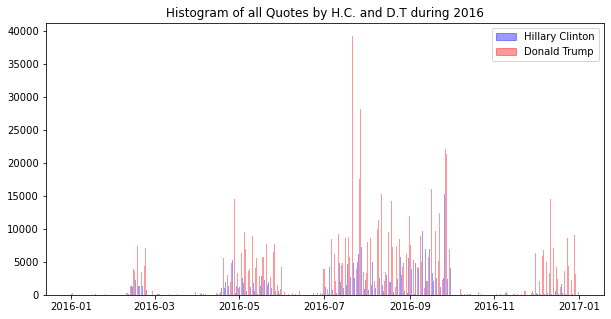

<Figure size 432x288 with 0 Axes>

In [13]:
#
# Histogram of all quotes grouped by Trump and CLinton for each day in 2016
#
def quotes_hist_split(df, n_bins=366): # One per day (366 days in 2016)

    plt.figure(figsize=(10,5))

    plt.title("Histogram of all Quotes by H.C. and D.T during 2016")

    df_hc = df[df['speaker'] == 'Hillary Clinton']
    df_dt = df[df['speaker'] == 'Donald Trump']

    plt.hist([df_hc['date'], df_dt['date']], weights=[df_hc['numOccurrences'], df_dt['numOccurrences']], bins=n_bins, color=["blue", "red"], alpha=0.4)

    plt.legend(handles=[blue_patch, red_patch])

    plt.show()
    plt.clf()

quotes_hist_split(df_3)

![Histogram of all (Quotebank) Quotes in 2016](assets/histogram-quotebank-quotes-2016.png)

After seing that there are suspicious periods of no or barely any quotes in the graph above we went back to the unfiltered (whole) dataset and plotted the distribution of all quote dates. The result can be seen in the graph above (computed in Google Colab) and suggests that this pattern is also present in the entire dataset, suggesting that this at least should not stem from a faulty filtration. 

**Note: The sharp dips are due to data outages on behalf of Spinn3r (From: Quotebank - A Corpus of Quotations from a Decade of News.pdf)**

In [ ]:
#
# Histogram of all occurances per quote grouped by Trump and CLinton for each day in 2016
#
def occ_hist_split(df, n_bins=100, use_log=True):
    
    fig, ax =  plt.subplots(figsize=(10,5))

    fig.suptitle("Histogram of the number of occurances of single quotes by H.C. and D.T during 2016", fontsize=14)

    df_hc = df[df['speaker'] == 'Hillary Clinton']
    df_dt = df[df['speaker'] == 'Donald Trump']
    ax.hist([df_hc['numOccurrences'], df_dt['numOccurrences']], log=use_log, bins=n_bins, color=["blue", "red"], alpha=0.4)

    ax.legend(handles=[blue_patch, red_patch])

    plt.show();
    plt.clf();

df_test = df_3.sort_values('numOccurrences', ascending=False)

display(df_test.head())
print()

#
#print(df_3[df_3['numOccurrences'] < 300].loc[85071])
#

occ_hist_split(df_test)

Check for duplictates in regards to the quote content

In [ ]:
df_3[df_3.duplicated(subset=['quotation'], keep=False)]

No duplicate quote, hence all quotations which have been used by multiple sources are indicated by the `numOccurances` column and further detailed by the list in the `urls` column.

### Proba assigned to Quotes

#### Investigation

**Motivation**

Certain quotes that the model assigned to Trump and Clinton have very low probabilities to actually be quotes by them inside of the text as by the computation of the model. We want to learn about the distribution of the probability of the assigned quotes so that we can take a decision on if and when to filter out certain quotes due to a too low probability computed for them by the model.

**Distribution of the Proba**

Here we plot the distribution of a sample of 1,000 Trump and 1,000 Clinton quotes respectively. The reason we sample seperatley is given the fact that we want to ensure a large enough sample pool for both candidates, which is needed since there are more quotes assigned to Trump than Clinton. We also plot the two seperatly to make sure that we do not miss any differences in the dsitribution.

In [ ]:
def probas_hist_split(df, on_sample=True, n_bins=20):
    
    if on_sample:
        _, dt_df, hc_df = get_df_samples(df)
    else:
        dt_df = df[df['speaker'] == 'Donald Trump']
        hc_df = df[df['speaker'] == 'Hillary Clinton']

    proba_bins = [round((1 / n_bins), 2) * i for i in range(0, n_bins  + 1)]

    fig, axs = plt.subplots(2, 2, figsize=(10, 5))
    fig.suptitle("Distribution of the probability computed by the model to the assigned speaker", fontsize=14)

    axs[0, 0].set(xlim=(0, 1))
    axs[0, 1].set(xlim=(0, 1))

    axs[0, 0].hist(hc_df['proba'], bins=proba_bins, color='blue', alpha=0.4)
    axs[0, 1].hist(dt_df['proba'], bins=proba_bins, color='red', alpha=0.4)

    axs[1, 0].set(xlim=(0, 1))
    axs[1, 1].set(xlim=(0, 1))

    axs[1, 0].boxplot(hc_df['proba'], vert=False)
    axs[1, 1].boxplot(dt_df['proba'], vert=False)


    axs[0, 0].set_ylabel('Frequency')
    axs[0, 0].title.set_text('Hillary Clinton (N={:,})'.format(len(hc_df)))

    axs[0, 1].title.set_text('Donald Trump (N={:,})'.format(len(dt_df)))

    axs[1, 1].set_xlabel('Computed Probability')
    axs[1, 0].set_xlabel('Computed Probability')

    plt.show()
    plt.clf()


#    
# Run on a random sample of 1,0000 quotes per speaker (for speed) 
#
example = df_3.copy()
probas_hist_split(example, on_sample=True)

    
print("Hillary Clinton Summary Statistics")
display(hc_sample['proba'].describe())
print()
print("Donald Trump Summary Statistics")
display(hc_sample['proba'].describe())

From plotting the distribution of probabilities which the model computed to the quotes it assigned to Trump and Hillary respectively we could now act in at least 3 ways:

1. Remove any quote which is below the min probability minus a small margin because they are outliers. **I.e. Only Remove outliers.**

2. Set the cutoff even higher because we decide to consider quotes with, ex. less than 0.4 probability assigned to the candidate being the speaker too weak to consider it in further analysis.

3. A further possibility could be to remove quotes, where the next best speaker assigned has a similair/close probability compare to the number one.
   
   Example: `[ [ 'Trump', 0.41 ], [ 'Kanye West', 0.39 ], ...]`

**TODO for later:** What should we do? What is scientifically sound? How do we motivate it?



**Filtering out datapoints with too low probability**

#### Filter Function

In [ ]:
#
# Function to remove quote with proba below a threshold.
#
def remove_low_proba_quotes(df, threshold):
    return df[df['proba'] >= threshold].copy()

example = df_3.copy()

example_threshold = 0.7

example = remove_low_proba_quotes(df_3, threshold=example_threshold)

n_removed_lines = len(df_3) - len(example)
percentage_removed = (n_removed_lines / len(df_3)) * 100

print("Result of filter with threshold: {:}\n".format(example_threshold))
print("Removed {:,.0f} datapoints or {:,.2f}% of the original dataset.\n".format(n_removed_lines, percentage_removed))

probas_hist_split(example, on_sample=True)

### Who are the speakers?

#### Investigation

In [ ]:
def display_speaker_breakdown(df):
    display(df.groupby(['speaker']).count().sort_values('quotation', ascending=False)['quotation'])

#
# Check out the unique speakers in our dataset
#
display_speaker_breakdown(df_3)

We see that our intial, rough, extraction algorithm extracted quotes by Trump's son and also some where Trump is titled "President". We assign will assign the "president" tittled quotes to Trump and filter out the  ones about his son.

#### Re-assignment Function

In [ ]:
#
# Function to assign quotes, where Trump is titlte "President" to his speaker name.
#
def assign_quotes_for_president_dt_to_dt(df):
    
    df = df.replace(
        to_replace=['president Donald Trump', 'PRESIDENT Donald Trump', 'President Donald Trump'],
        value='Donald Trump'
    )

    return df

example = df_3.copy()
example = assign_quotes_for_president_dt_to_dt(df_3)

n_removed_lines = len(df_3) - len(example)
percentage_removed = (n_removed_lines / len(df_3)) * 100

print("Result of filter:\n")
print("Removed {:,.0f} datapoints or {:,.2f}% of the original dataset.\n".format(n_removed_lines, percentage_removed))


display_speaker_breakdown(example)

#### Filter Function

In [ ]:
#
# Removes quotes by different speakers
#
def only_keep_dt_and_hc_quotes(df):
    return df[df['speaker'].isin(['Hillary Clinton', 'Donald Trump'])]

example = only_keep_dt_and_hc_quotes(example)

print("Result of filter: \n")
display_speaker_breakdown(example)

n_removed_lines = len(df_3) - len(example)
percentage_removed = (n_removed_lines / len(df_3)) * 100

print("\n")

print("Removed {:,.0f} datapoints or {:,.2f}% of the original dataset".format(n_removed_lines, percentage_removed))

### "Nonsense" content

**TODO**: We should ideally check for the quality of the quotes. There are certainly some faulty quotes and maybe even gibberish in the dataset but it is hopefully very limited in scope. We should nonetheless attempt to look for faulty/gibbersih quotes which were extracted by the model and remove them.

### The "data-gap"

In [ ]:
# Unique Quotes per day of entire 2016 Quotebbank
df_original_hist = pd.read_csv("data/unique-quotes-per-day-2016.csv")[['date', 'n_unique_quotes']]
df_original_hist['date'] = pd.to_datetime(df_original_hist['date'])

fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(15,5))

fig.suptitle("Distribution of Unique Quotes in Quotebank for 2016", fontsize=16)

left_ax.set_title("Trump and Clinton only")
left_ax.hist(df_3['date'], bins=366, color='purple', alpha=0.4)

right_ax.set_title("All Quotes")
right_ax.hist(df_original_hist['date'], weights=df_original_hist['n_unique_quotes'], bins=366, color='gray', alpha=0.4)

xticks = ['2016-03-15', '2016-06-15', '2016-09-15', '2016-12-15']
xticks_labels = ['15 March', '15 June', '15 September', '15 December']

left_ax.set_xticks(xticks)
left_ax.set_xticklabels(xticks_labels)

right_ax.set_xticks(xticks)
right_ax.set_xticklabels(xticks_labels)

plt.show()

plt.clf()

Let us take a closer look at the 4 gaps to determine a suitable threshold to drop quotes. For this we importantly do not use the gaps in the quotes of our 2 candidates, but rather the gaps in the global dataset. By  plotting the distribution of relative delta between the current day and next day we should be  able to narrow down the possibble cutoff days. 

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15,8))

fig.suptitle("Identifying the 'Cutoff' Dates", fontsize=16)

#
# First Gap
#
axs[0, 0].set_title("Gap: February - March")

gap = df_original_hist[(df_original_hist['date'] >= '2016-02-01') & (df_original_hist['date'] <= '2016-03-01')]
gap_days = len(gap)

_, bins, patches = axs[0, 0].hist(gap['date'], weights=gap['n_unique_quotes'], bins=gap_days, color='gray', alpha=0.4, edgecolor='black', linewidth=1.2)

xticks = ['2016-02-01', '2016-02-15', '2016-03-01']
xticks_labels = ['01 Feb', '15 Feb', '01 March']

axs[0, 0].set_xticks(xticks)
axs[0, 0].set_xticklabels(xticks_labels)

cutoff_left = '2016-02-12'
v_l = mlines.Line2D([cutoff_left, cutoff_left], [0,50_000], color='red')
axs[0, 0].add_line(v_l)
axs[0, 0].text(bins[6]-0.5, 50_000,  cutoff_left, style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.8, 'pad': 10})

cutoff_right = '2016-02-25'
v_l = mlines.Line2D([cutoff_right, cutoff_right], [0,50_000], color='red')
axs[0, 0].add_line(v_l)
axs[0, 0].text(bins[18]-0.5, 50_000,  cutoff_right, style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.8, 'pad': 10})

#
# Second Gap
#
axs[0, 1].set_title("Gap: April")

gap = df_original_hist[(df_original_hist['date'] >= '2016-04-07') & (df_original_hist['date'] <= '2016-05-01')]
gap_days = len(gap)

_, bins, patches = axs[0, 1].hist(gap['date'], weights=gap['n_unique_quotes'], bins=gap_days, color='gray', alpha=0.4, edgecolor='black', linewidth=1.2)

xticks = ['2016-04-07', '2016-04-15', '2016-05-01']
xticks_labels = ['07 April', '15 April', '01 May']

axs[0, 1].set_xticks(xticks)
axs[0, 1].set_xticklabels(xticks_labels)

cutoff_left = '2016-04-17'
v_l = mlines.Line2D([cutoff_left, cutoff_left], [0,50_000], color='red')
axs[0, 1].add_line(v_l)
axs[0, 1].text(bins[3], 50_000,  cutoff_left, style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.8, 'pad': 10})

#
# Third Gap
#
axs[0, 2].set_title("Gap: May - June")

gap = df_original_hist[(df_original_hist['date'] >= '2016-05-15') & (df_original_hist['date'] <= '2016-06-15')]
gap_days = len(gap)

_, bins, patches = axs[0, 2].hist(gap['date'], weights=gap['n_unique_quotes'], bins=gap_days, color='gray', alpha=0.4, edgecolor='black', linewidth=1.2)

xticks = ['2016-05-15', '2016-06-15']
xticks_labels = ['15 May', '15 June']

axs[0, 2].set_xticks(xticks)
axs[0, 2].set_xticklabels(xticks_labels)

cutoff_right = '2016-06-01'
v_l = mlines.Line2D([cutoff_right, cutoff_right], [0,50_000], color='red')
axs[0, 2].add_line(v_l)
axs[0, 2].text(bins[19], 50_000,  cutoff_right, style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.8, 'pad': 10})

#
# Fourth Gap
#
axs[1, 0].set_title("Gap: June - July")

gap = df_original_hist[(df_original_hist['date'] >= '2016-06-15') & (df_original_hist['date'] <= '2016-07-15')]
gap_days = len(gap)

_, bins, patches = axs[1, 0].hist(gap['date'], weights=gap['n_unique_quotes'], bins=gap_days, color='gray', alpha=0.4, edgecolor='black', linewidth=1.2)

xticks = ['2016-06-15', '2016-07-01', '2016-07-15']
xticks_labels = ['15 June', '01 July', '15 July']

axs[1, 0].set_xticks(xticks)
axs[1, 0].set_xticklabels(xticks_labels)

cutoff_right = '2016-06-30'
v_l = mlines.Line2D([cutoff_right, cutoff_right], [0,50_000], color='red')
axs[1, 0].add_line(v_l)
axs[1, 0].text(bins[6], 50_000,  cutoff_right, style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.8, 'pad': 10})

#
# Fifth Gap
#
axs[1, 1].set_title("Gap: September - October")

gap = df_original_hist[(df_original_hist['date'] >= '2016-09-15') & (df_original_hist['date'] <= '2016-10-15')]
gap_days = len(gap)

_, bins, patches = axs[1, 1].hist(gap['date'], weights=gap['n_unique_quotes'], bins=gap_days, color='gray', alpha=0.4, edgecolor='black', linewidth=1.2)

xticks = ['2016-09-15', '2016-10-01', '2016-10-15']
xticks_labels = ['15 September', '01 October', '15 October']

axs[1, 1].set_xticks(xticks)
axs[1, 1].set_xticklabels(xticks_labels)

cutoff_right = '2016-10-01'
v_l = mlines.Line2D([cutoff_right, cutoff_right], [0,50_000], color='red')
axs[1, 1].add_line(v_l)
axs[1, 1].text(bins[18], 50_000,  cutoff_right, style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.8, 'pad': 10})

#
# Sixt Gap
#
axs[1, 2].set_title("Gap: November - December")

gap = df_original_hist[(df_original_hist['date'] >= '2016-11-15') & (df_original_hist['date'] <= '2016-12-15')]
gap_days = len(gap)

_, bins, patches = axs[1, 2].hist(gap['date'], weights=gap['n_unique_quotes'], bins=gap_days, color='gray', alpha=0.4, edgecolor='black', linewidth=1.2)

xticks = ['2016-11-15', '2016-12-01', '2016-12-15']
xticks_labels = ['15 November', '01 December', '15 December']

axs[1, 2].set_xticks(xticks)
axs[1, 2].set_xticklabels(xticks_labels)

cutoff_right = '2016-11-30'
v_l = mlines.Line2D([cutoff_right, cutoff_right], [0,50_000], color='red')
axs[1, 2].add_line(v_l)
axs[1, 2].text(bins[6], 50_000,  cutoff_right, style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.8, 'pad': 10})

plt.show()

plt.clf()

In [ ]:
#
# Removes any quotes which are inside the data gaps as found above.
#
def remove_quotes_inside_data_gaps(df):
    df = df.copy()
    df = df[
        ( ('2016-02-12' <  df['date']) & (df['date'] < '2016-02-25') ) |
        ( ('2016-04-17' <  df['date']) & (df['date'] < '2016-06-01') ) |
        ( ('2016-06-30' <  df['date']) & (df['date'] < '2016-10-01') ) |
        ( ('2016-11-30' <  df['date']) & (df['date'] <= '2016-12-31') )
        
    ]
    
    return df

print("Pre Filter")
quotes_hist_split(df_3)
print("Post Filter")
example = remove_quotes_inside_data_gaps(df_3)
quotes_hist_split(example)

### Clean Data

Using our insights from the EDA we apply the different filters to "clean" our dataset, which is then ready for proper analysis.

In [ ]:
df_cleaned = df_2.copy()
print("Pre-Cleaning:  {:>10,} Quotes".format(len(df_cleaned)))

# Reassign quotes to Trump
df_cleaned = assign_quotes_for_president_dt_to_dt(df_cleaned)

# Remove quotes which are of  other speakers
df_cleaned = only_keep_dt_and_hc_quotes(df_cleaned)

# Remove any quote inside  our identified data gaps.
df_cleaned = remove_quotes_inside_data_gaps(df_cleaned)

n_removed = len(df_2) - len(df_cleaned)
per_removed = n_removed / len(df_2)
print("Removed:       {:>10,} Quotes or {:.2%} of the Original Data".format(n_removed, per_removed))
print("Post-Cleaning: {:>10,} Quotes".format(len(df_cleaned)))

df_cleaned.head()

In [ ]:
# NOTE: This should  be removed and is just so the code doesn't break after (Dean) having resturctured the cleaning process.
df_3_2 = df_cleaned.copy()

#### Sample

In [ ]:
cleaned_sample, dt_cleaned_sample, hc_cleaned_sample = get_df_samples(df_cleaned)

## 4. Our Focus Questions

###  Introduction & Background

#### What data  do we have?

In [ ]:
n_hc_quotes = sum(df_cleaned[df_cleaned['speaker'] == 'Hillary Clinton']['numOccurrences'])
n_dt_quotes = sum(df_cleaned[df_cleaned['speaker'] == 'Donald Trump']['numOccurrences'])

labels = 'Hillary', 'Trump'
sizes = [n_hc_quotes, n_dt_quotes]
explode = (0, 0.10)

fig, (left_ax, right_ax) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

fig.suptitle("Breakdown of Quotes",  fontsize=16)

#
# Amounted Quoted
#
left_ax.set_title("Times Quoted")

n_hc_quotes = sum(df_cleaned[df_cleaned['speaker'] == 'Hillary Clinton']['numOccurrences'])
n_dt_quotes = sum(df_cleaned[df_cleaned['speaker'] == 'Donald Trump']['numOccurrences'])
total_times_quoted = sum(df_cleaned['numOccurrences'])

left_ax.pie(
    [n_hc_quotes, n_dt_quotes],
    labels=labels,
    #autopct='%1.1f%%',
    autopct=lambda p: '{:,}'.format(round(p * total_times_quoted / 100)),
    colors=['blue', 'red'],
    startangle=90,
    textprops={'size': 'larger'},
    wedgeprops = {"alpha": 0.4})

#
# Unique  Quotes
#
right_ax.set_title("Unique Quotes")

n_unique_hc_quotes = len(df_cleaned[df_cleaned['speaker'] == 'Hillary Clinton'])
n_unique_dt_quotes = len(df_cleaned[df_cleaned['speaker'] == 'Donald Trump'])

right_ax.pie(
    [n_unique_hc_quotes, n_unique_dt_quotes],
    labels=labels,
    #autopct='%1.1f%%',
    autopct=lambda p: '{:,}'.format(round(p * len(df_cleaned) / 100)),
    colors=['blue', 'red'],
    startangle=90,
    textprops={'size': 'larger'},
    wedgeprops = {"alpha": 0.4})

plt.show()

### Q1: Media Bias

Do media outlets portray Trump and Clinton differently? Do media outlets quote the two candidates equally much? Does the bias of the news outlet correlate with the quotes they report?

Let's take two of the biggest outlets with political leaning views, CNN and Breitbart, and compare the distribution of Trump quotes with Clinton quotes, and also see how positive or negative they are.

The NLTK library will also be used for sentiment analysis later on.

In [ ]:
cleaned_sample.groupby(['speaker']).count().sort_values('quotation', ascending=False)['quotation']

**TODO:** Remove the wrong speakers...

#### Using NLTK’s Pre-Trained Sentiment Analyzer

We use NLTK VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tools

In [ ]:
sia = SentimentIntensityAnalyzer()

trump_polarity_scores = dt_cleaned_sample['quotation'].apply(sia.polarity_scores)
dt_sample['polarityScore'] = [score.get('compound') for score in trump_polarity_scores]

clinton_polarity_scores = hc_cleaned_sample['quotation'].apply(sia.polarity_scores)
hc_sample['polarityScore'] = [score.get('compound') for score in clinton_polarity_scores]

In [ ]:
trump_df = dt_cleaned_sample
clinton_df = hc_cleaned_sample

cnn_trump, cnn_clinton = [],[]

for i in range(len(trump_df)):
    for k in range(len(trump_df['urls'].iloc[i])):
        if trump_df['urls'].iloc[i][k].find('cnn') != -1:
            cnn_trump.append(i)

trump_cnn = trump_df.iloc[cnn_trump]

for i in range(len(clinton_df)):
    for k in range(len(clinton_df['urls'].iloc[i])):
        if clinton_df['urls'].iloc[i][k].find('cnn') != -1:
            cnn_clinton.append(i)

clinton_cnn = clinton_df.iloc[cnn_clinton]
        
trump_cnn_PS = trump_cnn['quotation'].apply(sia.polarity_scores)
trump_cnn['polarityScore'] = [score.get('compound') for score in trump_cnn_PS]
clinton_cnn_PS = clinton_cnn['quotation'].apply(sia.polarity_scores)
clinton_cnn['polarityScore'] = [score.get('compound') for score in clinton_cnn_PS]

trump_cnn_pos = trump_cnn[trump_cnn['polarityScore'] >= 0]
trump_cnn_neg = trump_cnn[trump_cnn['polarityScore'] < 0]
clinton_cnn_pos = clinton_cnn[clinton_cnn['polarityScore'] >= 0]
clinton_cnn_neg = clinton_cnn[clinton_cnn['polarityScore'] < 0]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].scatter(x=trump_cnn_pos['date'], y=trump_cnn_pos['polarityScore'], color='g', alpha=0.3, label="positive")
axs[0].scatter(x=trump_cnn_neg['date'], y=trump_cnn_neg['polarityScore'], color='r', alpha=0.3, label="negative")
axs[1].scatter(x=clinton_cnn_pos['date'], y=clinton_cnn_pos['polarityScore'], color='g', alpha=0.3, label="positive")
axs[1].scatter(x=clinton_cnn_neg['date'], y=clinton_cnn_neg['polarityScore'], color='r', alpha=0.3, label="positive")

fig.suptitle("CNN quotes compound polarity scores", fontsize=14)

axs[0].set_ylabel('Frequency')
axs[0].title.set_text('Donald Trump')

axs[1].title.set_text('Hillary Clinton')

axs[0].set_xlabel('Date')
axs[1].set_xlabel('Date')

axs[0].set_ylabel('Polarity score')
axs[1].set_ylabel('Polarity score')

plt.show()
plt.clf()

In [ ]:
breitbart_trump, breitbart_clinton = [],[]

for i in range(len(trump_df)):
    for k in range(len(trump_df['urls'].iloc[i])):
        if trump_df['urls'].iloc[i][k].find('breitbart') != -1:
            breitbart_trump.append(i)

trump_breitbart = trump_df.iloc[breitbart_trump]

for i in range(len(clinton_df)):
    for k in range(len(clinton_df['urls'].iloc[i])):
        if clinton_df['urls'].iloc[i][k].find('breitbart') != -1:
            breitbart_clinton.append(i)

clinton_breitbart = clinton_df.iloc[breitbart_clinton]
        
trump_breitbart_PS = trump_breitbart['quotation'].apply(sia.polarity_scores)
trump_breitbart['polarityScore'] = [score.get('compound') for score in trump_breitbart_PS]
clinton_breitbart_PS = clinton_breitbart['quotation'].apply(sia.polarity_scores)
clinton_breitbart['polarityScore'] = [score.get('compound') for score in clinton_breitbart_PS]

trump_breitbart_pos = trump_breitbart[trump_breitbart['polarityScore'] >= 0]
trump_breitbart_neg = trump_breitbart[trump_breitbart['polarityScore'] < 0]
clinton_breitbart_pos = clinton_breitbart[clinton_breitbart['polarityScore'] >= 0]
clinton_breitbart_neg = clinton_breitbart[clinton_breitbart['polarityScore'] < 0]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].scatter(x=trump_breitbart_pos['date'], y=trump_breitbart_pos['polarityScore'], color='g', alpha=0.3, label="positive")
axs[0].scatter(x=trump_breitbart_neg['date'], y=trump_breitbart_neg['polarityScore'], color='r', alpha=0.3, label="negative")
axs[1].scatter(x=clinton_breitbart_pos['date'], y=clinton_breitbart_pos['polarityScore'], color='g', alpha=0.3, label="positive")
axs[1].scatter(x=clinton_breitbart_neg['date'], y=clinton_breitbart_neg['polarityScore'], color='r', alpha=0.3, label="positive")

fig.suptitle("Breitbart quotes compound polarity scores", fontsize=14)

axs[0].set_ylabel('Frequency')
axs[0].title.set_text('Donald Trump')

axs[1].title.set_text('Hillary Clinton')

axs[0].set_xlabel('Date')
axs[1].set_xlabel('Date')

axs[0].set_ylabel('Polarity score')
axs[1].set_ylabel('Polarity score')

plt.show()
plt.clf()

This might be a very small sample size for the EDA, but we can already see substantial bias both in terms of the number of quotes by a candidate in each media outlet as well as the ratio of positive/negative quotes chosen by the CNN and Breitbart to represent the two Presidential candidates. This most likely holds true for other popular media outlets, especially those with politically inclined views.

### Q2: Political Topics

We want to track the different political topics that the candidates focused on according to the content of their quotes. From this we aim to learn the importance of the topics in a absolut relative context but also in regards to when a certain topic might have been very present and then. disappeared for some time. We furthermore want to see if there might be a candidate which sparked a topic or at least started talking/being quoted about it first.

Bewlow we show an example of a topic in regards to Obamacare, which we all remember to be a important topic during the debate.

#### Example: Obama Care

In [32]:
OBAMACARE_REGEX = '(obama care)|obamacare' # Not perfect, proof of concept...

df_obamacare = df_3_2[df_3_2['quotation'].str.contains(pat = OBAMACARE_REGEX, regex = True, flags=re.IGNORECASE)].sort_values('date')
df_obamacare['date'] = df_obamacare['date'].apply(lambda date : date.date())

df_obamacare_hc = df_obamacare[df_obamacare['speaker'] == 'Hillary Clinton']
df_obamacare_dt = df_obamacare[df_obamacare['speaker'] == 'Donald Trump']

/var/folders/w5/hs19vl4n2zsbxkgxg63pgg6c0000gn/T/ipykernel_52012/333532696.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df_obamacare = df_3_2[df_3_2['quotation'].str.contains(pat = OBAMACARE_REGEX, regex = True, flags=re.IGNORECASE)].sort_values('date')


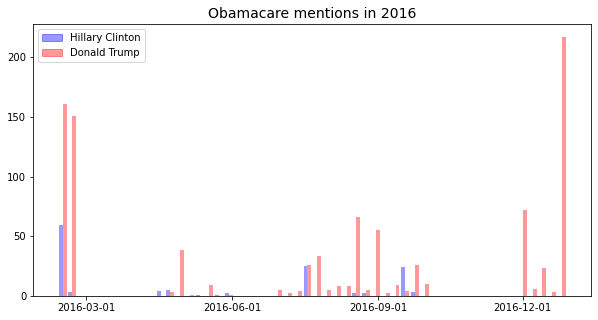

<Figure size 432x288 with 0 Axes>

In [33]:
BINS = 52
ticks = [f"2016-0{i * 3}-01" for i in range(1,4)] + ["2016-12-01"]

plt.figure(figsize=(10,5))
plt.title("Obamacare mentions in 2016", fontsize=14)

plt.hist([df_obamacare_hc['date'], df_obamacare_dt['date']], weights=[df_obamacare_hc['numOccurrences'], df_obamacare_dt['numOccurrences']], bins=BINS, color=["b", "r"], alpha=0.4)

plt.xticks(ticks)
plt.legend(handles=[blue_patch, red_patch])

plt.show()
plt.clf()

In [34]:
def quote_topics_histogram(df_hc, df_dt, bins=52, topic_name=""):
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    kwargs = {
        "alpha" : 0.4,
        "bins": bins,
    }

    axs[0].hist(df_hc['date'], weights=df_hc['numOccurrences'], color="b", **kwargs)
    axs[1].hist(df_dt['date'], weights=df_dt['numOccurrences'], color="r", **kwargs)

    fig.suptitle("Mentions of the Topic {} in 2016 by candidate".format(topic_name), fontsize=16)

    axs[0].set_ylabel('Frequency')

    axs[0].title.set_text('Hillary Clinton')
    axs[0].set_xlabel('Date')

    axs[1].title.set_text('Donald Trump')
    axs[1].set_xlabel('Date')
    
    ticks = [f"2016-0{i * 3}-01" for i in range(1,4)] + ["2016-12-01"]

    axs[0].set_xticks(ticks)
    axs[1].set_xticks(ticks)
    
    plt.show()
    plt.clf()

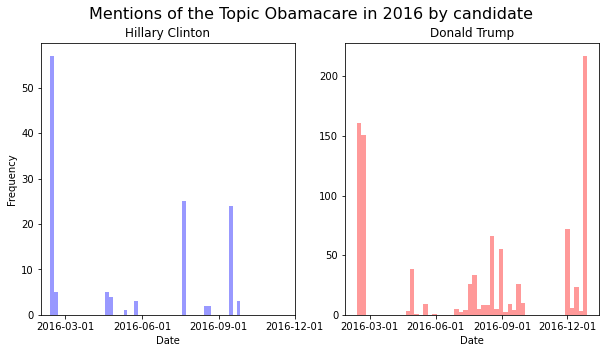

<Figure size 432x288 with 0 Axes>

In [35]:
# Example:
quote_topics_histogram(df_obamacare_hc, df_obamacare_dt, topic_name="Obamacare")

#### Important Interrlude

Hillary Clinton talked less about Obamacare but instead more about Healthcare... To be explored further!

#### Visualisation Idea

We have identified several topics which show a clear periodic difference in occurance and intensity. We aim to visualise this data as illustrated in the sketch below for the final project. We hope to show how several topics come and go throughout the campaign and are focused on with a different amount of attention/importance depending on the candidate. Ideally we would extend this visualisation further allowing the viewer to see the importance the citizen base gave the topics at each time or the extent to which media reported on it. It would be amazing to see if some topics had a trendsetter who started talking about it earier adn fiercly...

We believe that our first EDA supports our thesis that the data will allow us to visualise it in this way, that there is peridoicity and hoepefully many interesting insights.

![Visualisation Sketch](assets/focus-topics-sketch.jpg)

#### Topic Extraction

### Q3: Language

#### a) Intellectuality of Language

Idea 1: Count the syllables in each candidate's consolidated quotes and compare distributions

In [48]:
def syllables_hist(dt_syl, hc_syl):

    args_dt = dict(
        name=DT,
        marker={"color":px.colors.qualitative.Plotly[1]},
        x=dt_syl,
        histnorm="probability density",
    )
    
    args_hc = dict(
        name=HC,
        marker={"color":px.colors.qualitative.Plotly[0]},
        x=hc_syl,
        histnorm="probability density",
    )

    fig = go.Figure()
    
    fig.add_trace(go.Histogram(args_dt))
    fig.add_trace(go.Histogram(args_hc))
    
    fig.update_layout(
        font=dict(
            size=16,
        )
    )
    fig.update_layout( 
        font_family="Rockwell",
        legend=dict(
            title=None, orientation="h", y=1, yanchor="bottom", x=0.5, xanchor="center"
        ),
        title="Histogram of number of syllables",
        xaxis_title="Number of syllables in a word",
        yaxis_title="Probability of occuring",
        legend_title="Speaker",
        title_x=0.5,
        width=750,
        height=400,
    )
    
    fig.show()

In [157]:
def syl(quotes_col):
    df = pd.DataFrame()
    df["word"] = ' '.join(quotes_col).split()
    df["syllables"] = df["word"].apply(syllables.estimate)
    return df

dt_syl = syl(dt_cleaned_sample["quotation"])
hc_syl = syl(hc_cleaned_sample["quotation"])

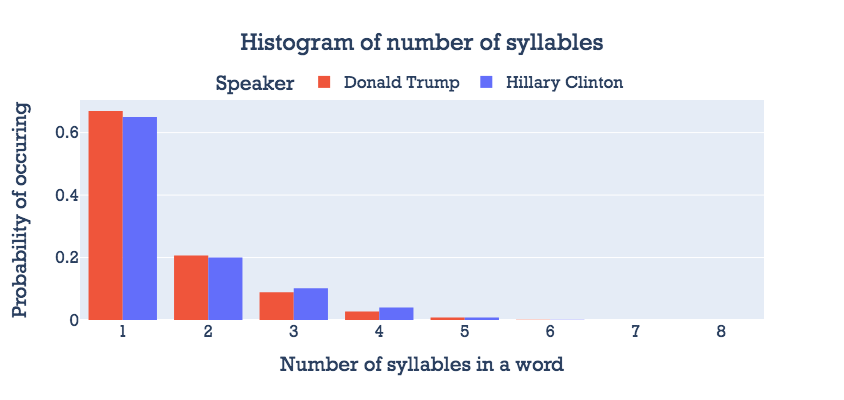

In [158]:
syllables_hist(dt_syl["syllables"], hc_syl["syllables"])

Idea 2: Look at the CEFR language level. We can measure the language level for all words in each candidate's consolidated quotes and compare the distributions.

In [39]:
cefr_data = pd.read_csv(CEFR_CLEAN_CSV_IN, index_col="word")
cefr_data.loc["he"].loc["level"]

1.0

In [75]:
def cefr_level_hist(dt_level, hc_level):
    
    args = dict(
        histnorm="probability density",
        xbins=dict(
            start=0,
            end=6,
            size=1,
        ),
    )
    
    args_dt = dict(
        **args,
        x=dt_level,
        name=DT,
        marker=dict(color=px.colors.qualitative.Plotly[1]),
    )
    
    args_hc = dict(
        **args,
        x=hc_level,
        name=HC,
        marker=dict(color=px.colors.qualitative.Plotly[0]),
    )

    fig = go.Figure()
    
    fig.add_trace(go.Histogram(args_dt))
    fig.add_trace(go.Histogram(args_hc))
    
    fig.update_layout(
        font=dict(
            size=16,
        ),
        font_family="Rockwell",
        legend=dict(
            title=None, orientation="h", y=1, yanchor="bottom", x=0.5, xanchor="center"
        ),
        title="Histogram of English level of words",
        xaxis_title="English level",
        yaxis_title="Probability of occuring",
        legend_title="Speaker",
        title_x=0.5,
        width=750,
        height=400,
    )
    
    fig.update_xaxes(
        ticktext=["NA", "A1", "A2", "B1", "B2", "C1", "C2"],
        tickvals=list([i + 0.5 for i in range(0, 6)])
    )
    
    fig.show()

In [156]:
cefr_data = pd.read_csv(CEFR_CLEAN_CSV_IN, index_col="word")

def should_skip(word):
    # Punctuation, proper nouns, strings contains a digit
    return word.is_punct or\
           word.pos_ == "PROPN" or\
           any(char.isdigit() for char in word.text) or\
           word.text in ["$", "'d", "'s", "`"]
    
def df_level(quotes_col):
    level = lambda w: cefr_data.loc[w].loc["level"] if w in cefr_data.index else 0
    
    # Use Spacy to normalise words
    s = sp(' '.join(quotes_col))
    words = []
    for w in s:
        # Deal with special cases
        if should_skip(w):
            continue
        elif w.lemma_ == "-PRON-":
            words.append(w.text.lower())
        else:
            words.append(w.lemma_)
    
    df = pd.DataFrame()
    df["word"] = words
    df["level"] = df["word"].apply(level)
    return df
    
hc_level = df_level(hc_cleaned_sample["quotation"])
dt_level = df_level(dt_cleaned_sample["quotation"])

In [163]:
df =dt_level[dt_level.level == 4]
df.groupby("word").count().sort_values("level", ascending=False).head(10)

,level
word,
one,64
put,22
talk,22
support,18
state,18
deal,17
send,17
question,16
nation,16


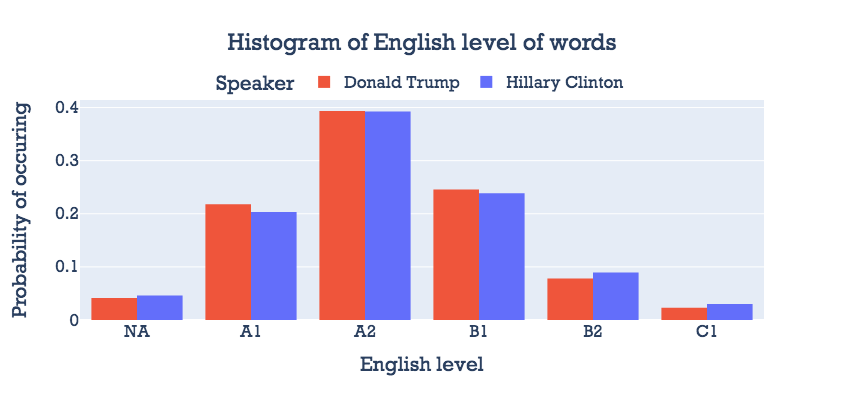

In [153]:
cefr_level_hist(dt_level["level"], hc_level["level"])

There seems to be little difference in terms of language levels. None of the words in our dataset 

#### b) Sentiment Analysis

In [ ]:
cleaned_sample.groupby(['speaker']).count().sort_values('quotation', ascending=False)['quotation']

##### Using NLTK’s Pre-Trained Sentiment Analyzer
We use NLTK VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tools

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
trump_polarity_scores = dt_cleaned_sample['quotation'].apply(sia.polarity_scores)
dt_cleaned_sample['polarityScore'] = [score.get('compound') for score in trump_polarity_scores]

clinton_polarity_scores = hc_cleaned_sample['quotation'].apply(sia.polarity_scores)
hc_cleaned_sample['polarityScore'] = [score.get('compound') for score in clinton_polarity_scores]

#### Donald Trump's 5 most positive and negative quotes

In [ ]:
print("Trump's 5 most positive quotes:")
# trump_df.sort_values('polarityScore', ascending=False)[['quotation', 'polarityScore']].head(5)
[print("\n[+]", quote) for quote in dt_cleaned_sample.sort_values('polarityScore', ascending=False)['quotation'].head(5).tolist()]

print("\n---\n")

print("Trump's 5 most negative quotes:")
# trump_df.sort_values('polarityScore', ascending=True)[['quotation', 'polarityScore']].head(5).tolist()
[print("\n[-]", quote) for quote in dt_cleaned_sample.sort_values('polarityScore', ascending=True)['quotation'].head(5).tolist()]


#### Hillary Clinton's 5 most positive and negative quotes

In [ ]:
print("Hillary Clinton's 5 most positive quotes:")
# clinton_df.sort_values('polarityScore', ascending=False)[['quotation', 'polarityScore']].head(5)
[print("\n[+]", quote) for quote in hc_cleaned_sample.sort_values('polarityScore', ascending=False)['quotation'].head(5).tolist()]

print("\n---\n")

print("Hillary Clinton's 5 most negative quotes:")
# clinton_df.sort_values('polarityScore', ascending=True)[['quotation', 'polarityScore']].head(5).tolist()
[print("\n[-]", quote) for quote in hc_cleaned_sample.sort_values('polarityScore', ascending=True)['quotation'].head(5).tolist()]


In [ ]:
trump_df_pos = dt_sample[dt_sample['polarityScore'] >= 0]
trump_df_neg = dt_sample[dt_sample['polarityScore'] < 0]

plt.scatter(x=trump_df_pos['date'], y=trump_df_pos['polarityScore'], color='g', alpha=0.3, label="positive")
plt.scatter(x=trump_df_neg['date'], y=trump_df_neg['polarityScore'], color='r', alpha=0.3, label="negative")

plt.title("Trump's quotes compound polarity scores by date in 2016")
plt.xlabel('Date')
plt.ylabel('Polarity score')
plt.legend()

plt.show()

In [ ]:
clinton_df_pos = hc_sample[hc_sample['polarityScore'] >= 0]
clinton_df_neg = hc_sample[hc_sample['polarityScore'] < 0]

plt.scatter(x=clinton_df_pos['date'], y=clinton_df_pos['polarityScore'], color='g', alpha=0.3, label="positive")
plt.scatter(x=clinton_df_neg['date'], y=clinton_df_neg['polarityScore'], color='r', alpha=0.3, label="negative")

plt.title("Clinton's quotes compound polarity scores by date in 2016")
plt.xlabel('Date')
plt.ylabel('Polarity score')
plt.legend()

plt.show()

In [ ]:
trump_df_pos.head()

### Sentiment analysis on the target of quotes. 

For instance, Trump calling Clinton "Crooked Hillary" would be a negative statement about Presidential candidate Clinton. This will be done for a number of politicians, including: Hillary Clinton, Nancy Pelosi, Barack Obama, Bernie Sanders, Elizabeth Warren, Ted Cruz, Mike Pence, and Mitch McConnell.

In [ ]:
trump_df = sample.loc[sample['speaker'] == 'Donald Trump']
clinton_df = sample.loc[sample['speaker'] == 'Hillary Clinton']

trump_on_clinton = trump_df[trump_df['quotation'].str.contains('clinton|hillary', case=False)]
trump_on_obama = trump_df[trump_df['quotation'].str.contains('obama|barack', case=False)]
trump_on_sanders = trump_df[trump_df['quotation'].str.contains('bernie|sanders', case=False)]

clinton_on_trump = clinton_df[clinton_df['quotation'].str.contains('trump|donald', case=False)]

In [ ]:
trump_on_clinton_PS = trump_on_clinton['quotation'].apply(sia.polarity_scores)
trump_on_clinton['polarityScore'] = [score.get('compound') for score in trump_on_clinton_PS]

trump_on_obama_PS = trump_on_obama['quotation'].apply(sia.polarity_scores)
trump_on_obama['polarityScore'] = [score.get('compound') for score in trump_on_obama_PS]

In [ ]:
trump_on_clinton_pos = trump_on_clinton[trump_on_clinton['polarityScore'] >= 0]
trump_on_clinton_neg = trump_on_clinton[trump_on_clinton['polarityScore'] < 0]

plt.scatter(x=trump_on_clinton_pos['date'], y=trump_on_clinton_pos['polarityScore'], color='g', alpha=0.3, label="positive")
plt.scatter(x=trump_on_clinton_neg['date'], y=trump_on_clinton_neg['polarityScore'], color='r', alpha=0.3, label="negative")

plt.title("Trump's Hillary-targeted quotes compound polarity scores by date in 2016")
plt.xlabel('Date')
plt.ylabel('Polarity score')
plt.legend()

plt.show()

In [ ]:
trump_on_obama_pos = trump_on_obama[trump_on_obama['polarityScore'] >= 0]
trump_on_obama_neg = trump_on_obama[trump_on_obama['polarityScore'] < 0]

plt.scatter(x=trump_on_obama_pos['date'], y=trump_on_obama_pos['polarityScore'], color='g', alpha=0.3, label="positive")
plt.scatter(x=trump_on_obama_neg['date'], y=trump_on_obama_neg['polarityScore'], color='r', alpha=0.3, label="negative")

plt.title("Trump's Obama-targeted quotes compound polarity scores by date in 2016")
plt.xlabel('Date')
plt.ylabel('Polarity score')
plt.legend()

plt.show()

Perhaps a next step would be to compare this with a baseline ratio of positive/negative words. For instance, maybe on average people say 70% positive things and 30% negative. Knowing this could help compare results with Trump and Clinton.

### Using BERT for sentiment analysis using quote vector embedding

In [ ]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
trump_df['quotation'].iloc[500]

In [ ]:
# Add the special tokens.
trump_df['marked'] = "[CLS] " + trump_df['quotation'] + " [SEP]"

trump_df['tokenized'] = trump_df['marked']
trump_df['indexed'] = trump_df['marked']
trump_df['seg_ids'] = trump_df['marked']
trump_df['tokens_tensor'] = trump_df['marked']
trump_df['seg_tensors'] = trump_df['marked']

# Split the sentence into tokens.
for i in range(len(trump_df)):
    trump_df['tokenized'].iloc[i] = tokenizer.tokenize(trump_df['marked'].iloc[i])
    # Map the token strings to their vocabulary indeces.
    trump_df['indexed'].iloc[i] = tokenizer.convert_tokens_to_ids(trump_df['tokenized'].iloc[i])
    trump_df['seg_ids'].iloc[i] = [1] * len(trump_df['tokenized'].iloc[i])
    # Convert inputs to PyTorch tensors
    trump_df['tokens_tensor'].iloc[i] = torch.tensor([trump_df['indexed'].iloc[i]])
    trump_df['seg_tensors'].iloc[i] = torch.tensor([trump_df['seg_ids'].iloc[i]])

#### BERT Next Steps

The next step is to evaluate BERT on our quotations, and fetch the hidden states of the network. We would then create word and sentence vectors from our hidden states. This creates 768-dimensional token embedding vectors, on which we can then apply principal component analysis to plot the results using 2 axes.